In [ ]:
!pip install tensorflow-datasets



In [4]:

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LambdaCallback

In [5]:


class LRFinder:
    """
    Learning rate range test detailed in Cyclical Learning Rates for Training
    Neural Networks by Leslie N. Smith. The learning rate range test is a test
    that provides valuable information about the optimal learning rate. During
    a pre-training run, the learning rate is increased linearly or
    exponentially between two boundaries. The low initial learning rate allows
    the network to start converging and as the learning rate is increased it
    will eventually be too large and the network will diverge.
    """

    def __init__(self, model):
        self.model = model
        self.losses = []
        self.learning_rates = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        lr = K.get_value(self.model.optimizer.lr)
        self.learning_rates.append(lr)

        loss = logs['loss']
        self.losses.append(loss)

        if batch > 5 and (math.isnan(loss) or loss > self.best_loss * 4):
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)

    def find(self, dataset, start_lr, end_lr, epochs=1,
             steps_per_epoch=None, **kw_fit):
        if steps_per_epoch is None:
            raise Exception('To correctly train on the datagenerator,'
                            '`steps_per_epoch` cannot be None.'
                            'You can calculate it as '
                            '`np.ceil(len(TRAINING_LIST) / BATCH)`')

        self.lr_mult = (float(end_lr) /
                        float(start_lr)) ** (float(1) /
                                             float(epochs * steps_per_epoch))
        initial_weights = self.model.get_weights()

        original_lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch,
                                  logs: self.on_batch_end(batch, logs))

        self.model.fit(dataset,
                       epochs=epochs, callbacks=[callback], **kw_fit)
        self.model.set_weights(initial_weights)

        K.set_value(self.model.optimizer.lr, original_lr)

    def get_learning_rates(self):
        return(self.learning_rates)

    def get_losses(self):
        return(self.losses)

    def get_derivatives(self, sma):
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.learning_rates)):
            derivatives.append((self.losses[i] - self.losses[i - sma]) / sma)
        return derivatives

    def get_best_lr(self, sma, n_skip_beginning=10, n_skip_end=5):
        derivatives = self.get_derivatives(sma)
        best_der_idx = np.argmin(derivatives[n_skip_beginning:-n_skip_end])
        return self.learning_rates[n_skip_beginning:-n_skip_end][best_der_idx]

In [ ]:
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)
train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

for s, l in train_data:
    training_sentences.append(str(s.numpy()))
    training_labels.append(l.numpy())

for s, l in test_data:
    testing_sentences.append(str(s.numpy()))
    testing_labels.append(l.numpy())

training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [7]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = ""

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok) 
tokenizer.fit_on_texts(training_sentences) 
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences) 
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Epoch 1/5
49/49 [==============================] - 14s 291ms/step - loss: 0.3447 - accuracy: 0.8620
Epoch 2/5
49/49 [==============================] - 14s 291ms/step - loss: 0.3267 - accuracy: 0.8702
Epoch 3/5
49/49 [==============================] - 14s 290ms/step - loss: 0.2990 - accuracy: 0.8770
Epoch 4/5
49/49 [==============================] - 14s 292ms/step - loss: 0.3201 - accuracy: 0.8657
Epoch 5/5
49/49 [==============================] - 15s 297ms/step - loss: 0.6807 - accuracy: 0.6389


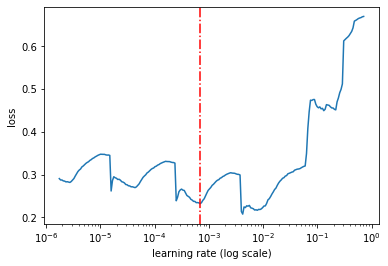

In [10]:
BATCH = 512
train_ds = tf.data.Dataset.from_tensor_slices((padded, training_labels_final))
train_ds = train_ds.batch(BATCH)
STEPS_PER_EPOCH = np.ceil(len(train_data) / BATCH)
lr_finder = LRFinder(model)
lr_finder.find(train_ds, start_lr=1e-6, end_lr=1, epochs=5,
               steps_per_epoch=STEPS_PER_EPOCH)
               
learning_rates = lr_finder.get_learning_rates()
losses = lr_finder.get_losses()

def plot_loss(learning_rates, losses, n_skip_beginning=10, n_skip_end=5, x_scale='log'):
    f, ax = plt.subplots()
    ax.set_ylabel("loss")
    ax.set_xlabel("learning rate (log scale)")
    ax.plot(learning_rates[n_skip_beginning:-n_skip_end],
            losses[n_skip_beginning:-n_skip_end])
    ax.set_xscale(x_scale)
    return(ax)

axs = plot_loss(learning_rates,losses)
axs.axvline(x=lr_finder.get_best_lr(sma=20), c='r', linestyle='-.')

In [11]:
best_lr = lr_finder.get_best_lr(sma=20)
K.set_value(model.optimizer.lr, best_lr)

In [12]:
earlystop_callback = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=3)
model.fit(padded, training_labels_final, epochs=10, validation_data=(
    testing_padded, testing_labels_final), callbacks=[earlystop_callback])
model.evaluate(testing_padded)

Epoch 1/10
782/782 [==============================] - 78s 100ms/step - loss: 0.3008 - accuracy: 0.8774 - val_loss: 0.3757 - val_accuracy: 0.8364
Epoch 2/10
782/782 [==============================] - 78s 100ms/step - loss: 0.2424 - accuracy: 0.9090 - val_loss: 0.4042 - val_accuracy: 0.8356
Epoch 3/10
782/782 [==============================] - 78s 100ms/step - loss: 0.2003 - accuracy: 0.9286 - val_loss: 0.4269 - val_accuracy: 0.8314
Epoch 4/10
782/782 [==============================] - 2s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00


[0.0, 0.0]